In [11]:
import requests      # Библиотека для отправки запросов
import numpy as np   # Библиотека для матриц, векторов и линала
import pandas as pd  # Библиотека для табличек 
import time          # Библиотека для времени
import json
from tqdm import tqdm_notebook

import threading
from threading import Thread

In [12]:
!pip install fake_useragent

In [13]:
from fake_useragent import UserAgent

In [14]:
from bs4 import BeautifulSoup

In [15]:
def getPageLinks(keyword, page_number):  
    # Запрашиваем данные
    response = requests.get('https://www.labirint.ru/search/' + keyword + '/',
                            params={'page': page_number},
                            headers={'User-Agent': UserAgent().chrome})
    
    if not response.ok: return [] 
    
    # Получаем содержимое страницы и переводим в суп
    soup = BeautifulSoup(response.content,'html.parser')
    
    # Находим ссылки
    list_div = soup.findAll('div', attrs={'class': 'product need-watch '})

    links = ['https://www.labirint.ru' + div.find('a', attrs={'class': 'cover'}).attrs['href'] for div in list_div]
    
    return links

In [16]:
def getDescription(link):  
    # Запрашиваем данные
    response = requests.get(link, headers={'User-Agent': UserAgent().chrome})
    
    if not response.ok: return [] 
    
    # Получаем содержимое страницы и переводим в суп
    soup = BeautifulSoup(response.content,'html.parser')
    
    # Оценка товара
    rating = soup.find('div', attrs={'id': 'rate'}).string

    # Оценка товара
    annotation = soup.find('div', attrs={'id': 'fullannotation'})

    if annotation == None: return {'rating': float(rating), 'text': ''}

    return {'rating': float(rating), 'text': ' '.join([s for s in annotation.p.stripped_strings])}

In [17]:
# Находим ссылки всех страниц
links = []
for kword in ['прир', 'биз', 'пти', 'иде', 'трен']:
  for page_num in range(1, 18, 1):
    links_ = getPageLinks(kword, page_num)
    if len(links_) == 0: break
    time.sleep(0.1)
    links += links_

links = list(set(links))   # Удаляем повторяющиеся, если есть

In [18]:
links[: 10]

['https://www.labirint.ru/books/683185/',
 'https://www.labirint.ru/books/533963/',
 'https://www.labirint.ru/books/687200/',
 'https://www.labirint.ru/books/475914/',
 'https://www.labirint.ru/books/840972/',
 'https://www.labirint.ru/books/759149/',
 'https://www.labirint.ru/books/607121/',
 'https://www.labirint.ru/books/825237/',
 'https://www.labirint.ru/books/297880/',
 'https://www.labirint.ru/books/805160/']

In [19]:
def build_data(links, datalist, idx_start, idx_end):
  for link in links[idx_start : idx_end]:
    data = getDescription(link)
    datalist.append(data)
    time.sleep(0.1)

In [20]:
datalist = []

count = len(links) // 10             # Разбиваем чтение данных на 10 + 1 потоков

cur_count = 0
for idx in range(count, len(links), count):
    cur_count = idx
    th = Thread(target=build_data, args=(links, datalist, idx - count, idx))
    th.start()

if cur_count != len(links):
    th = Thread(target=build_data, args=(links, datalist, cur_count, len(links)))
    th.start()

print('Всего ссылок: ', len(links))

while len(datalist) != len(links):
  time.sleep(60)
  print('Прочитано ссылок: ', len(datalist))

Всего ссылок:  4877
Прочитано ссылок:  122
Прочитано ссылок:  291
Прочитано ссылок:  459
Прочитано ссылок:  630
Прочитано ссылок:  797
Прочитано ссылок:  963
Прочитано ссылок:  1133
Прочитано ссылок:  1296
Прочитано ссылок:  1470
Прочитано ссылок:  1638
Прочитано ссылок:  1796
Прочитано ссылок:  1952
Прочитано ссылок:  2096
Прочитано ссылок:  2236
Прочитано ссылок:  2389
Прочитано ссылок:  2540
Прочитано ссылок:  2693
Прочитано ссылок:  2864
Прочитано ссылок:  3027
Прочитано ссылок:  3191
Прочитано ссылок:  3360
Прочитано ссылок:  3532
Прочитано ссылок:  3701
Прочитано ссылок:  3868
Прочитано ссылок:  4031
Прочитано ссылок:  4189
Прочитано ссылок:  4367
Прочитано ссылок:  4534
Прочитано ссылок:  4695
Прочитано ссылок:  4851
Прочитано ссылок:  4877


In [21]:
# Удаляем данные без описания или без оценки
print('Кол-во ссылок: ', len(datalist))

datalist = [data for data in datalist if data['text'] != '' and data['rating'] != 0.0]

print('Кол-во ссылок с данными: ', len(datalist))

Кол-во ссылок:  4877
Кол-во ссылок с данными:  727


In [22]:
datalist[:2]

[{'rating': 10.0,
  'text': '"Представьте двух бизнесменов в кимоно. Пусть это будет поединок. Один, известный на рынке игрок, наступает. Другой, неокрепший новичок, всю жизнь работал в другой сфере, только пришел на этот рынок и теперь должен держать удар. Скажете, у второго нет шансов? А вот и нет. Если знать правильные приемы, встречную энергию противника можно направить на благо себе. Вместо "акулы бизнеса" условным противником "новичка" может быть что угодно. Внешние обстоятельства, подрядчики, контрагенты, клиенты, даже собственная жена или совершенно незнакомые люди на улице. Правильными приемами я, Андрей Лушников, и хочу с вами поделиться. Очень часто всё, что у вас получается в жизни легко и как будто "в потоке", - и есть айкибизнес". Правила ведения бизнеса в стиле айкидо пригодятся всем: бизнесменам, начинающим предпринимателям, людям, только мечтающим о бизнесе, наемным специалистам, мужьям, женам, наконец водителям автомобилей - они работают везде, вне зависимости от пола

In [23]:
import string # библиотека для работы со строками
import nltk   # Natural Language Toolkit

In [24]:
# загружаем список стоп-слов для русского
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
word_tokenizer = nltk.WordPunctTokenizer()

In [26]:
dates = [str(x) for x in np.arange(1800, 2022)]
def process_data(data):
    texts = []
    targets = []
    
    # поочередно проходим по всем новостям в списке
    for item in data:               
        text_lower = item['text'].lower() # приводим все слова к нижнему регистру
        tokens     = word_tokenizer.tokenize(text_lower) # разбиваем текст на слова
        
        # удаляем пунктуацию и стоп-слова
        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and word not in dates and not ('(' in word) and not (')' in word))]
        
        texts.append(tokens) # добавляем в предобработанный список
    
    return texts

**Удаляем пунктуацию и стоп-слова.**

In [81]:
# запускаем предобработку
y = [item['rating'] for item in datalist]
texts = process_data(datalist)

In [82]:
# example
i = 0
print("Label: ", y[i])
print("Tokens: ", texts[i])

Label:  10.0
Tokens:  ['представьте', 'двух', 'бизнесменов', 'кимоно', 'пусть', 'это', 'поединок', 'известный', 'рынке', 'игрок', 'наступает', 'неокрепший', 'новичок', 'жизнь', 'работал', 'сфере', 'пришел', 'рынок', 'должен', 'держать', 'удар', 'скажете', 'второго', 'шансов', 'знать', 'правильные', 'приемы', 'встречную', 'энергию', 'противника', 'направить', 'благо', 'вместо', 'акулы', 'бизнеса', 'условным', 'противником', 'новичка', 'угодно', 'внешние', 'обстоятельства', 'подрядчики', 'контрагенты', 'клиенты', 'собственная', 'жена', 'совершенно', 'незнакомые', 'люди', 'улице', 'правильными', 'приемами', 'андрей', 'лушников', 'хочу', 'вами', 'поделиться', 'очень', 'часто', 'всё', 'получается', 'жизни', 'легко', 'потоке', '",', 'айкибизнес', '".', 'правила', 'ведения', 'бизнеса', 'стиле', 'айкидо', 'пригодятся', 'всем', 'бизнесменам', 'начинающим', 'предпринимателям', 'людям', 'мечтающим', 'бизнесе', 'наемным', 'специалистам', 'мужьям', 'женам', 'водителям', 'автомобилей', 'работают', '

**Нормализуем слова.**

In [83]:
#!pip install pymorphy2

In [84]:
# загружаем библиотеку для лемматизации
import pymorphy2 # Морфологический анализатор

# инициализируем лемматизатор :)
morph = pymorphy2.MorphAnalyzer()

In [85]:
# применяем лемматизацию ко всем текстам
for i in tqdm_notebook(range(len(texts))):           # tqdm_notebook создает шкалу прогресса :)
    text_lemmatized = [morph.parse(x)[0].normal_form for x in texts[i]] # применяем лемматизацию для каждого слова в тексте
    texts[i] = ' '.join(text_lemmatized)                # объединяем все слова в одну строку через пробел

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/727 [00:00<?, ?it/s]

In [86]:
i = 0
print("Label: ",   y[i])
print("Text: \n",  texts[i])

Label:  10.0
Text: 
 представить два бизнесмен кимоно пусть это поединок известный рынок игрок наступать неокрепший новичок жизнь работать сфера прийти рынок должный держать удар сказать второй шанс знать правильный приём встречный энергия противник направить благо вместо акула бизнес условный противник новичок угодный внешний обстоятельство подрядчик контрагент клиент собственный жена совершенно незнакомый человек улица правильный приём андрей лушник хотеть вы поделиться очень часто всё получаться жизнь легко поток ", айкибизнес ". правило ведение бизнес стиль айкидо пригодиться весь бизнесмен начинающий предприниматель человек мечтать бизнес наёмный специалист муж жена водитель автомобиль работать везде вне зависимость пол возраст опыт профессия социальный финансовый положение ваш собеседник андрей лушник предприниматель 30 летний стаж м основать зао бестъ компания управление недвижимый имущество стоимость актив оцениваться 4 5 миллиард рубль общий капитализация компания составлять о

**Моделирование.**

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score
from sklearn.model_selection import StratifiedKFold

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.rcParams["figure.figsize"] = (20, 8)

In [88]:
stratify = np.array(y).astype(np.int16)
stratify[stratify < 2] = 2

train_texts, test_texts, train_y, test_y = train_test_split(texts, y, test_size=0.25, random_state=42, stratify=stratify)

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Fit TF-IDF on train texts
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.8, min_df=0.1, norm="l1", max_features = 50)
# Обучаем TF-IDF на train, а затем применяем к train и test
train_X = vectorizer.fit_transform(train_texts)
test_X  = vectorizer.transform(test_texts)

In [90]:
train_X.todense()[:2] # посмотрим на первые 2 строки

matrix([[0.0256651 , 0.        , 0.        , 0.        , 0.03476079,
         0.        , 0.        , 0.06026636, 0.        , 0.        ,
         0.15482339, 0.        , 0.        , 0.        , 0.0643213 ,
         0.04045955, 0.        , 0.        , 0.        , 0.        ,
         0.08583052, 0.        , 0.04156775, 0.        , 0.0635308 ,
         0.03495004, 0.        , 0.        , 0.        , 0.14034109,
         0.        , 0.032484  , 0.04171202, 0.        , 0.04355241,
         0.        , 0.        , 0.02671395, 0.        , 0.03240255,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.03153283, 0.        , 0.04508555],
        [0.        , 0.04250264, 0.        , 0.        , 0.03878408,
         0.        , 0.04066339, 0.13448344, 0.        , 0.06918248,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.06771364, 0.09307971, 0.        , 0.        , 0.        ,
         0.        , 0.07572696, 

In [91]:
vectorizer.get_feature_names()[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['автор',
 'бизнес',
 'быть',
 'ваш',
 'весь',
 'вопрос',
 'время',
 'год',
 'другой',
 'жизнь']

In [92]:
gs = GridSearchCV(estimator=ElasticNet(),
                  param_grid=[{"alpha": np.arange(0.01, 1.01, 0.01),
                               "l1_ratio": np.arange(0.01, 1.01, 0.01)}],
                  scoring="neg_root_mean_squared_error",
                  cv=7)

gs.fit(train_X, train_y)

print(gs.best_score_, gs.best_params_)

-1.7071506807802237 {'alpha': 0.01, 'l1_ratio': 0.01}


In [103]:
clf = ElasticNet(alpha=0.01, l1_ratio=0.01)
clf.fit(train_X, train_y)

pred_y = clf.predict(test_X)

print(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), max_error(test_y, pred_y), r2_score(test_y, pred_y))

1.1850612625405796 2.672617383919768 7.680856085110307 0.028850631619638634


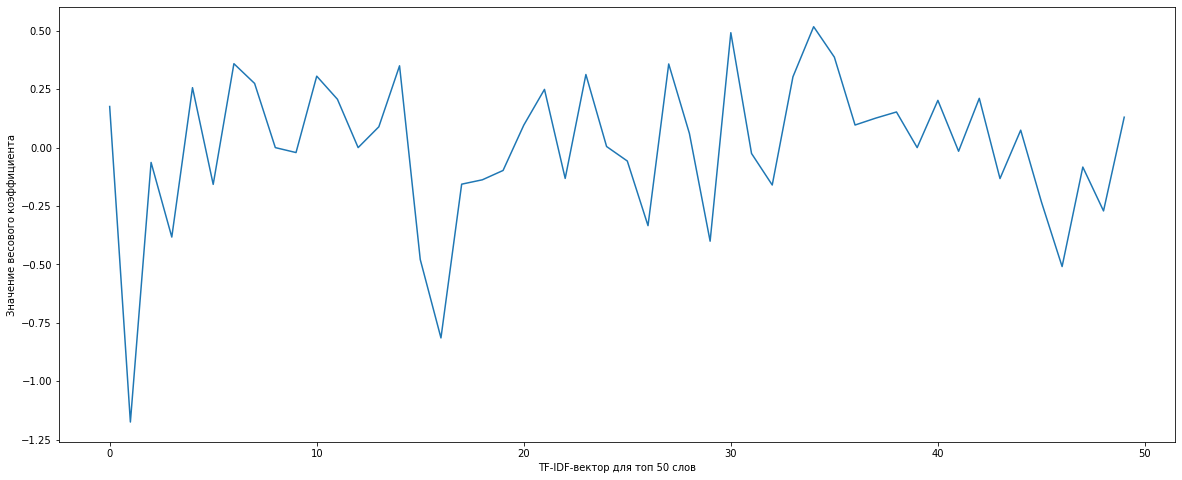

In [98]:
fig, ax = plt.subplots()

plt.plot(range(clf.coef_.shape[0]), clf.coef_)

ax.set_xlabel('TF-IDF-вектор для топ 50 слов')
ax.set_ylabel('Значение весового коэффициента')

plt.show()

По данной модели можно сделать приблизительные выводы о будущем рейтинге книги. Максимальная ошибка составляет 7.68 баллов, средняя 1.18. Средняя ошибка не плохо, но максимальная пугает, но все равно какие-то выводы о книге по ее краткому описанию модель позволяет сделать. Данный не совсем удовлетворительный результат, я считаю, связан с неравномерностью распределения данных по рейтингам, как показоно ниже, а также с тем, что описание книги и ее рейтинг в данном случае связаны не напрямую, т.к. оценку ставят за время доставки книги, качество печати, за ее содержимое в целом и т.п.

Можно сказать, что модель точна на столько на сколько высоко качество входных данных, в данном случае качество входных данных для обучения модели невысокое.

In [99]:
np.unique(np.array(y).astype(np.int16), return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int16),
 array([ 10,   4,   5,  11,  30,  38,  59, 147, 219, 204]))